### 테스트 데이터셋 만들기
훈련하는게 아니므로 train은 생략.

In [49]:
import sys
import os

# 프로젝트의 절대 경로를 수동으로 추가 (이 경로를 본인의 프로젝트 경로로 변경!)
project_root = "/Users/yunseongmun/Documents/CVDclassification-based-on-ECG-signals/"

if project_root not in sys.path:
    sys.path.append(project_root)

# sys.path 확인
print("Added to sys.path:", project_root)

# import 시도
try:
    from ver5_journal.common.data.ECG_Data import ECG_Data
    from ver5_journal.common.data.create_final_data import create_final_data
    print("Module import 성공!")
except ModuleNotFoundError as e:
    print("Module import 실패:", e)


Added to sys.path: /Users/yunseongmun/Documents/CVDclassification-based-on-ECG-signals/
Module import 성공!


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,1,0,0,0,0
1,38,17076.0,40.0,0,NaN,72.0,2.0,0.0,CS-12 E,1985-02-15 11:48:22,...,NaN,NaN,10,records100/00000/00038_lr,records500/00000/00038_hr,1,0,0,0,0
2,40,19501.0,60.0,0,NaN,85.0,2.0,0.0,CS-12 E,1985-02-20 11:43:45,...,NaN,NaN,10,records100/00000/00040_lr,records500/00000/00040_hr,1,0,0,0,0
3,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,1,0,0,0,0
4,59,19475.0,54.0,0,NaN,67.0,2.0,0.0,CS-12 E,1985-06-12 06:36:01,...,NaN,NaN,10,records100/00000/00059_lr,records500/00000/00059_hr,1,0,0,0,0


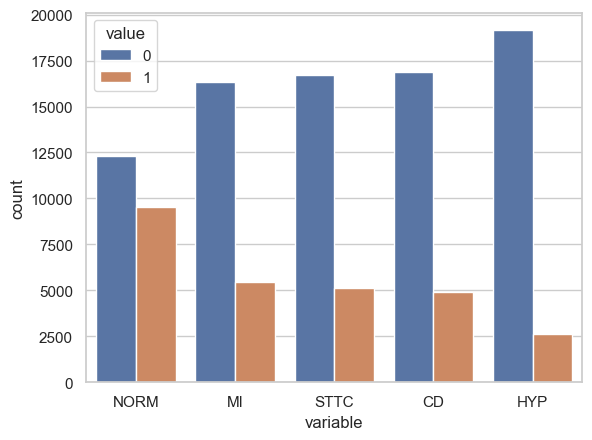

In [50]:
from torch.utils.data import DataLoader
from ver5_journal.common.data.ECG_Data import ECG_Data
from ver5_journal.common.data.create_final_data import create_final_data

final_data=create_final_data()

ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=32, shuffle=False)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(test_dataset,batch_size=32, shuffle=False)

ECG_test.head()

In [51]:
# 레이블 컬럼 리스트
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

# 각 레이블별 개수
label_counts = ECG_test[label_columns].sum()

# 전체 샘플 수
total_samples = len(ECG_test)

# 각 레이블의 비율 계산
label_ratios = label_counts / total_samples

# 출력
print("📌 각 레이블별 개수:")
print(label_counts)
print("\n📌 각 레이블별 비율:")
print(label_ratios)

📌 각 레이블별 개수:
NORM    963
MI      550
STTC    506
CD      496
HYP     262
dtype: int64

📌 각 레이블별 비율:
NORM    0.438126
MI      0.250227
STTC    0.230209
CD      0.225660
HYP     0.119199
dtype: float64


In [52]:
import subprocess
import time
import torch
import numpy as np

loss_fn = torch.nn.BCELoss()
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

y_true = []
y_pred = []
total_test_loss = 0  # 테스트 전체 Loss 저장

def get_power_usage():
    """powermetrics를 실행하여 CPU/GPU 전력 소비량을 가져옴"""
    sudo_password = "1004"  # ⚠️ 실제 비밀번호 입력 (보안 문제 주의!)
    cmd = f"echo {sudo_password} | sudo -S powermetrics --samplers cpu_power,gpu_power -n 1"

    result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    output = result.stdout
    error_output = result.stderr

    print("stdout output:", output)
    print("stderr output:", error_output)

    if error_output:
        print("🚨 powermetrics 실행 중 에러 발생!")
        return None, None

    cpu_power = None
    gpu_power = None
    for line in output.split("\n"):
        if "CPU Power:" in line:
            try:
                print(f'CPU line: {line}')
                cpu_power = float(line.split(":")[1].strip().split("mW")[0])  # mW 값 가져오기
            except ValueError:
                print("⚠️ CPU 전력 값을 읽을 수 없습니다:", line)

        if "GPU Power:" in line:
            try:
                print(f'GPU line: {line}')
                gpu_power = float(line.split(":")[1].strip().split("mW")[0])  # mW 값 가져오기
            except ValueError:
                print("⚠️ GPU 전력 값을 읽을 수 없습니다:", line)

    if cpu_power is None:
        print("🚨 CPU 전력 값을 가져오지 못했습니다.")
    if gpu_power is None:
        print("🚨 GPU 전력 값을 가져오지 못했습니다.")

    return cpu_power, gpu_power



# 🔥 모델 실행 전 소비 전력 측정
cpu_power_before, gpu_power_before = get_power_usage()
time_start = time.time()

# 🔥 테스트 코드 실행 (여기에 모델 실행 코드 삽입)
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        batch_predictions = []
        batch_loss = 0  

        for idx, model in enumerate(best_models):
            output = model(data)
            output = torch.sigmoid(output).squeeze(-1)
            label_data = label[:, idx].float()
            loss = loss_fn(output, label_data)
            batch_loss += loss.item()
            predictions = (output.detach().cpu().numpy() > optimal_thresholds[idx]).astype(int)
            batch_predictions.append(predictions)

        batch_loss /= len(best_models)  
        total_test_loss += batch_loss  
        batch_predictions = np.array(batch_predictions).T  
        y_true.extend(label.cpu().numpy())  
        y_pred.extend(batch_predictions)    

# 🔥 모델 실행 후 소비 전력 측정
cpu_power_after, gpu_power_after = get_power_usage()
time_end = time.time()

# 총 소비 전력 계산 (평균 전력 * 실행 시간)
elapsed_time = time_end - time_start
cpu_energy_used = (cpu_power_after + cpu_power_before) / 2 * elapsed_time
gpu_energy_used = (gpu_power_after + gpu_power_before) / 2 * elapsed_time

# 분류기 개수로 나누어 평균 소비 전력 계산
avg_cpu_power_per_model = cpu_energy_used / len(best_models)
avg_gpu_power_per_model = gpu_energy_used / len(best_models)

print(f"CPU 총 소비 전력: {cpu_energy_used:.2f} J")
print(f"GPU 총 소비 전력: {gpu_energy_used:.2f} J")
print(f"각 이진 분류기의 평균 CPU 소비 전력: {avg_cpu_power_per_model:.2f} J")
print(f"각 이진 분류기의 평균 GPU 소비 전력: {avg_gpu_power_per_model:.2f} J")

stdout output: Machine model: MacBookAir10,1
OS version: 24C101
Boot arguments: 
Boot time: Mon Feb  3 00:55:00 2025



*** Sampled system activity (Fri Feb 21 04:27:55 2025 +0900) (5006.56ms elapsed) ***


**** Processor usage ****

E-Cluster HW active frequency: 2064 MHz
E-Cluster HW active residency: 100.00% (600 MHz:   0% 972 MHz:   0% 1332 MHz:   0% 1704 MHz:   0% 2064 MHz: 100%)
E-Cluster idle residency:   0.00%
CPU 0 frequency: 2064 MHz
CPU 0 active residency:  95.06% (600 MHz:   0% 972 MHz:   0% 1332 MHz:   0% 1704 MHz:   0% 2064 MHz:  95%)
CPU 0 idle residency:   4.94%
CPU 1 frequency: 2064 MHz
CPU 1 active residency:  94.67% (600 MHz:   0% 972 MHz:   0% 1332 MHz:   0% 1704 MHz:   0% 2064 MHz:  95%)
CPU 1 idle residency:   5.33%
CPU 2 frequency: 2064 MHz
CPU 2 active residency:  94.58% (600 MHz:   0% 972 MHz:   0% 1332 MHz:   0% 1704 MHz:   0% 2064 MHz:  95%)
CPU 2 idle residency:   5.42%
CPU 3 frequency: 2064 MHz
CPU 3 active residency:  93.99% (600 MHz:   0% 972 MHz:   0% 13

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
from ver5_journal.common.BCRnetwork.BCResNets import BCResNets
import torch
import numpy as np
from sklearn.metrics import classification_report

# 모델 순서 정의
sequence = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

total = 0
# 저장된 각 모델을 로드하여 리스트에 저장
for dd in sequence:
    model_path = f'../common/best_models/{dd}_model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
    # model.load_state_dict(torch.load(model_path, weights_only=True))
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)
    # 모델의 전체 파라미터 수를 계산
    param = sum(p.numel() for p in model.parameters())
    total += param
    print(f"{dd} parameters: {param}")

# 모델의 전체 파라미터 수를 계산
print(f"total param: {total}")

NORM parameters: 27769
MI parameters: 27769
STTC parameters: 27769
CD parameters: 27769
HYP parameters: 27769
total param: 138845


### val 데이터셋으로 최적의 threshold 찾기

In [ ]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

optimal_thresholds = []
auc_values = []

# 각 분류기에서 Youden's J 통계량을 사용해 최적 임계값을 찾는 코드
for idx, model in enumerate(best_models):
    y_true = []
    y_scores = []

    # 테스트 데이터셋에서 예측 결과 저장
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)


            # 각 배치 내 모든 샘플에 대해 처리
            for i in range(data.size(0)):
                sample = data[i].unsqueeze(0)
                output = model(sample)
                output = torch.sigmoid(output).item()  # 확률 값으로 변환
                y_scores.append(output)  # 스코어 저장
                y_true.append(label[i, idx].item())  # 해당 클래스에 대한 실제값 저장


    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    
    # Youden's J 통계량 계산 (TPR - FPR)
    youdens_j = tpr - fpr
    
    # Youden's J가 최대인 임계값 찾기
    optimal_idx = np.argmax(youdens_j)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold) 

    # AUC도 계산
    auc_value = auc(fpr, tpr)
    auc_values.append(auc_value)

    print(f'Classifier {sequence[idx]} - AUC: {auc_value:.4f}')
    print(f'Optimal threshold for classifier {sequence[idx]} using Youden\'s J: {optimal_threshold:.4f}')
    

Classifier NORM - AUC: 0.9422
Optimal threshold for classifier NORM using Youden's J: 0.4685
Classifier MI - AUC: 0.9236
Optimal threshold for classifier MI using Youden's J: 0.3026
Classifier STTC - AUC: 0.9317
Optimal threshold for classifier STTC using Youden's J: 0.3310
Classifier CD - AUC: 0.9208
Optimal threshold for classifier CD using Youden's J: 0.4901
Classifier HYP - AUC: 0.9090
Optimal threshold for classifier HYP using Youden's J: 0.4097


### 이진 분류기 평균 소비 전력 측정

In [ ]:
import subprocess
import time
import torch
import numpy as np

loss_fn = torch.nn.BCELoss()
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

y_true = []
y_pred = []
total_test_loss = 0  # 테스트 전체 Loss 저장

def get_power_usage():
    """powermetrics를 실행하여 CPU/GPU 소비 전력을 가져옴 (mW 단위)"""
    sudo_password = "1004"  # ⚠️ 보안 문제 주의 (sudoers 설정 권장)
    cmd = f"echo {sudo_password} | sudo -S powermetrics --samplers cpu_power,gpu_power -n 1"
    result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    output = result.stdout

    cpu_power = None
    gpu_power = None

    for line in output.split("\n"):
        if "CPU Power:" in line:
            cpu_power = float(line.split(":")[1].strip().split("mW")[0])
        if "GPU Power:" in line:
            gpu_power = float(line.split(":")[1].strip().split("mW")[0])

    return cpu_power, gpu_power


def measure_model_energy_with_test(test_loader, best_models, optimal_thresholds, device):
    """ 특정 시간 동안 모델 실행 전후의 전력 소비량 비교 (mJ 단위 유지) """
    total_cpu_energy = 0  # mJ (milliJoule)
    total_gpu_energy = 0  # mJ (milliJoule)

    start_time = time.time()

    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            batch_predictions = []
            batch_loss = 0  

            for idx, model in enumerate(best_models):
                # 🎯 모델 실행 전 소비 전력 측정
                cpu_power_before, gpu_power_before = get_power_usage()

                # ⏳ 모델 실행 (여기서 실제 연산 수행)
                output = model(data)

                # 🎯 모델 실행 후 소비 전력 측정
                cpu_power_after, gpu_power_after = get_power_usage()

                # 🏆 모델 실행 동안의 전력 소비량 계산 (mW * sec → mJ)
                if cpu_power_before is not None and cpu_power_after is not None:
                    cpu_energy_used = (cpu_power_before + cpu_power_after) / 2  # 평균 소비 전력
                    total_cpu_energy += cpu_energy_used  # 누적 전력

                if gpu_power_before is not None and gpu_power_after is not None:
                    gpu_energy_used = (gpu_power_before + gpu_power_after) / 2  # 평균 소비 전력
                    total_gpu_energy += gpu_energy_used  # 누적 전력

                # 🔥 모델 예측값 계산
                output = torch.sigmoid(output).squeeze(-1)
                label_data = label[:, idx].float()
                loss = torch.nn.BCELoss()(output, label_data)
                batch_loss += loss.item()
                predictions = (output.detach().cpu().numpy() > optimal_thresholds[idx]).astype(int)
                batch_predictions.append(predictions)

            batch_loss /= len(best_models)  
            batch_predictions = np.array(batch_predictions).T  
            y_true.extend(label.cpu().numpy())  
            y_pred.extend(batch_predictions)    

    end_time = time.time()
    elapsed_time = end_time - start_time  # ⏳ 실행 시간 (초)

    # 🏆 모델 실행 중 누적된 소비 전력 계산 (mJ 단위 유지)
    total_cpu_energy *= elapsed_time
    total_gpu_energy *= elapsed_time

    return total_cpu_energy, total_gpu_energy, elapsed_time


# 🔥 모델 실행 중 전력 측정
print("🚀 [테스트 시작] 모델 실행 중 전력 측정...")
cpu_energy, gpu_energy, elapsed_time = measure_model_energy_with_test(test_loader, best_models, optimal_thresholds, device)

print("\n=== 🔥 최종 결과 ===")
print(f"🔥 모델 실행 중 누적 CPU 소비 전력: {cpu_energy:.2f} mJ")
print(f"🔥 모델 실행 중 누적 GPU 소비 전력: {gpu_energy:.2f} mJ")
print(f"⏳ 총 테스트 실행 시간: {elapsed_time:.2f} 초")
print("=========================")


🚀 [테스트 시작] 모델 실행 중 전력 측정...


KeyboardInterrupt: 

In [ ]:
import subprocess
import time
import torch
import numpy as np

loss_fn = torch.nn.BCELoss()
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

y_true = []
y_pred = []
total_test_loss = 0  # 테스트 전체 Loss 저장

def get_battery_capacity():
    """ioreg를 사용하여 현재 배터리 잔량(mAh) 가져오기"""
    cmd = ["ioreg", "-l", "-w", "0"]
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    output = result.stdout
    for line in output.split("\n"):
        if "AppleRawCurrentCapacity" in line:
            try:
                capacity = int(line.split("=")[1].strip())  # 배터리 잔량 (mAh)
                return capacity
            except ValueError:
                print("⚠️ 배터리 용량을 읽을 수 없습니다:", line)

    print("🚨 배터리 잔량을 가져오지 못했습니다.")
    return None


def measure_model_energy_with_test(test_loader, best_models, optimal_thresholds, device):
    """ 모델 실행 전후의 배터리 소비 전력 측정 (Joules) """
    
    total_energy_used_j = 0  # 전체 소비 전력 (J)
    start_time = time.time()

    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            batch_predictions = []
            batch_loss = 0  

            for idx, model in enumerate(best_models):
                # 🎯 모델 실행 전 배터리 용량 확인
                battery_before = get_battery_capacity()
                print(f"🔋 모델 실행 전 배터리 용량: {battery_before} mAh")

                # ⏳ 모델 실행 (연산 수행)
                output = model(data)

                # 🎯 모델 실행 후 배터리 용량 확인
                battery_after = get_battery_capacity()
                print(f"🔋 모델 실행 후 배터리 용량: {battery_after} mAh")

                # 🏆 모델 실행 중 배터리 소비량 계산
                if battery_before is not None and battery_after is not None:
                    battery_used = battery_before - battery_after  # 사용된 배터리 (mAh)
                    
                    # 평균 배터리 전압 (V) → macOS에서는 일반적으로 3.8V ~ 4.2V 사용
                    battery_voltage = 3.8  # V (평균값 사용)
                    
                    # 전력(W) 계산: Wh = (mAh × V) / 1000
                    energy_used_wh = (battery_used * battery_voltage) / 1000  # Wh 단위 변환
                    energy_used_j = energy_used_wh * 3600  # J (Joule) 단위 변환
                    total_energy_used_j += energy_used_j  # 누적 전력 사용량

                # 🔥 모델 예측값 계산
                output = torch.sigmoid(output).squeeze(-1)
                label_data = label[:, idx].float()
                loss = torch.nn.BCELoss()(output, label_data)
                batch_loss += loss.item()
                predictions = (output.detach().cpu().numpy() > optimal_thresholds[idx]).astype(int)
                batch_predictions.append(predictions)

            batch_loss /= len(best_models)  
            batch_predictions = np.array(batch_predictions).T  
            y_true.extend(label.cpu().numpy())  
            y_pred.extend(batch_predictions)    

    end_time = time.time()
    elapsed_time = end_time - start_time  # ⏳ 실행 시간 (초)

    return total_energy_used_j, elapsed_time


# 🔥 모델 실행 중 전력 측정
print("🚀 [테스트 시작] 모델 실행 중 전력 측정...")
energy_used_j, elapsed_time = measure_model_energy_with_test(test_loader, best_models, optimal_thresholds, device)

print("\n=== 🔥 최종 결과 ===")
print(f"🔥 모델 실행 중 누적 소비 전력: {energy_used_j:.2f} J")
print(f"⏳ 총 테스트 실행 시간: {elapsed_time:.2f} 초")
print("=========================")


In [ ]:
import subprocess
import time

def get_power_usage():
    """powermetrics를 실행하여 CPU/GPU 소비 전력을 가져옴 (mW 단위)"""
    sudo_password = "1004"  # ⚠️ 실제 비밀번호 입력 (보안 문제 주의!)
    cmd = f"echo {sudo_password} | sudo -S powermetrics --samplers cpu_power,gpu_power -n 1"
    result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    output = result.stdout

    if result.stderr:
        print("🚨 powermetrics 실행 중 에러 발생!")
        print(result.stderr)

    cpu_power = None
    gpu_power = None

    for line in output.split("\n"):
        if "CPU Power:" in line:
            cpu_power = float(line.split(":")[1].strip().split("mW")[0])
            print(f'CPU: {cpu_power}')

        if "GPU Power:" in line:
            gpu_power = float(line.split(":")[1].strip().split("mW")[0])
            print(f'GPU: {gpu_power}')


    return cpu_power, gpu_power


def measure_total_energy(duration=10, interval=1):
    """ 특정 시간 동안 누적 소비 전력 측정 (Joules) """
    total_cpu_energy = 0  # mJ (milliJoule)
    total_gpu_energy = 0  # mJ (milliJoule)

    start_time = time.time()
    while time.time() - start_time < duration:
        cpu_power, gpu_power = get_power_usage()

        if cpu_power is not None and gpu_power is not None:
            total_cpu_energy += cpu_power * interval  # mW * sec → mJ
            total_gpu_energy += gpu_power * interval  # mW * sec → mJ

        time.sleep(interval)

    # mJ → J 변환
    total_cpu_energy /= 1000
    total_gpu_energy /= 1000

    return total_cpu_energy, total_gpu_energy

# 🔥 테스트 실행 (예: 60초 동안 측정)
duration = 60  # 총 측정 시간 (초)
interval = 1   # 샘플링 간격 (초)

get_power_usage()

print("🚀 [테스트 시작] 누적 소비 전력 측정 시작...")
cpu_energy, gpu_energy = measure_total_energy(duration, interval)
print(f"🔥 누적 CPU 소비 전력: {cpu_energy:.2f} J")
print(f"🔥 누적 GPU 소비 전력: {gpu_energy:.2f} J")
print(f"⏳ 총 측정 시간: {duration} 초")


🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 3164.0
GPU: 81.0
GPU: 81.0
🚀 [테스트 시작] 누적 소비 전력 측정 시작...
🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 3097.0
GPU: 64.0
GPU: 64.0
🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 2931.0
GPU: 39.0
GPU: 39.0
🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 2931.0
GPU: 37.0
GPU: 37.0
🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 2947.0
GPU: 36.0
GPU: 36.0
🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 3486.0
GPU: 18.0
GPU: 18.0
🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 3355.0
GPU: 46.0
GPU: 46.0
🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 3030.0
GPU: 55.0
GPU: 55.0
🚨 powermetrics 실행 중 에러 발생!
Password:
CPU: 3121.0
GPU: 50.0
GPU: 50.0
🔥 누적 CPU 소비 전력: 24.90 J
🔥 누적 GPU 소비 전력: 0.34 J
⏳ 총 측정 시간: 60 초


### 테스트 전
CPU Power: 6939 mW
GPU Power: 94 mW
ANE Power: 0 mW
Combined Power (CPU + GPU + ANE): 7034 mW

### 테스트 후
CPU Power: 6341 mW
GPU Power: 59 mW
ANE Power: 0 mW
Combined Power (CPU + GPU + ANE): 6400 mW

45.86 초

### 단계 없이 모든 분류기를 거치는 테스트 케이스
1. val dataset에서 구한 최적의 임계값 사용
2. 각 분류기의 개별 지표(classification_report) 및 통합 지표(Hamming Loss) 시각화

In [ ]:
import torch
import numpy as np

loss_fn = torch.nn.BCELoss()
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

y_true = []
y_pred = []
total_test_loss = 0  # 테스트 전체 Loss 저장

# 테스트 데이터셋을 연결된 모델에 사용
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)

        # 각 데이터 포인트별로 모든 클래스에 대한 예측값을 저장하기 위한 리스트
        batch_predictions = []
        batch_loss = 0  # 배치에 대한 Loss 저장

        # 각 분류기에 대해 예측값을 얻음 (모델을 순차적으로 실행)
        for idx, model in enumerate(best_models):
            output = model(data)  # 각 모델이 배치에 대한 예측값을 출력 (배치 크기만큼의 값 반환)
            output = torch.sigmoid(output).squeeze(-1)  # Sigmoid 함수 적용 후 배치 크기 유지

            # 실제 레이블에서 해당 클래스만 선택
            label_data = label[:, idx].float()  # 각 클래스에 대한 실제 레이블  
            loss = loss_fn(output, label_data)  # 각 클래스에 대한 Loss 계산
            batch_loss += loss.item()  # 배치에 대한 Loss 누적

            # 최적 임계값 적용하여 각 모델의 출력이 임계값을 넘으면 1, 아니면 0으로 설정
            predictions = (output.detach().cpu().numpy() > optimal_thresholds[idx]).astype(int)
            batch_predictions.append(predictions)

        # 배치에 대한 평균 Loss 계산
        batch_loss /= len(best_models)  # 각 모델별로 계산된 Loss의 평균
        total_test_loss += batch_loss  # 배치별 Loss를 전체 테스트 Loss에 누적

        # 모든 클래스에 대한 예측값을 저장
        batch_predictions = np.array(batch_predictions)  # (num_models, batch_size) 형태
        batch_predictions = batch_predictions.T  # (batch_size, num_models) 형태로 변환

        # 각 샘플에 대해 예측값과 실제값 저장
        y_true.extend(label.cpu().numpy())  # 실제값 (멀티레이블)
        y_pred.extend(batch_predictions)    # 예측값 (멀티레이블)

In [ ]:
from sklearn.metrics import hamming_loss
# 평가 지표 계산
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 각 레이블별 Classification Report 계산
for i, label_name in enumerate(label_columns):
    print(f"\nClassification Report for Label: {label_name}")
    report = classification_report(y_true[:, i], y_pred[:, i], target_names=[f'{label_name}_0', f'{label_name}_1'], zero_division=0)
    print(report)

# 멀티레이블 전체의 통합 지표 계산 (MacroAUC, Hamming Loss)
# Macro AUC 계산 (각 클래스 AUC 값의 평균)
macro_auc = np.mean(auc_values)
print(f'Macro AUC: {macro_auc:.4f}')
hamming = hamming_loss(y_true, y_pred)
print(f'Hamming Loss with optimal thresholds: {hamming:.4f}')


Classification Report for Label: NORM
              precision    recall  f1-score   support

      NORM_0       0.92      0.84      0.87      1235
      NORM_1       0.81      0.90      0.85       963

    accuracy                           0.86      2198
   macro avg       0.86      0.87      0.86      2198
weighted avg       0.87      0.86      0.87      2198


Classification Report for Label: MI
              precision    recall  f1-score   support

        MI_0       0.95      0.84      0.89      1648
        MI_1       0.65      0.86      0.74       550

    accuracy                           0.85      2198
   macro avg       0.80      0.85      0.81      2198
weighted avg       0.87      0.85      0.85      2198


Classification Report for Label: STTC
              precision    recall  f1-score   support

      STTC_0       0.95      0.86      0.90      1692
      STTC_1       0.64      0.86      0.74       506

    accuracy                           0.86      2198
   macro avg 

### NORM이 true일 경우, 나머지 분류기를 안거치는 테스트 케이스
위에서 구한 예측값에서 NORM이 1인 경우, 나머지를 0으로 바꿔서 테스트

In [ ]:
from sklearn.metrics import hamming_loss
# NORM 클래스가 1인 경우 다른 클래스는 모두 0으로 설정한 y_pred2 생성
y_pred2 = y_pred.copy()
norm_true_indices = np.where(y_pred[:, 0] == 1)[0]
y_pred2[norm_true_indices, 1:] = 0  # NORM=1인 샘플에 대해 나머지 클래스 0

# 각 레이블별 Classification Report 계산
for i, label_name in enumerate(label_columns):
    print(f"\nClassification Report for Label: {label_name}")
    report = classification_report(y_true[:, i], y_pred2[:, i], target_names=[f'{label_name}_0', f'{label_name}_1'], zero_division=0)
    print(report)

# 멀티레이블 전체의 통합 지표 계산 (MacroAUC, Hamming Loss)
# Macro AUC 계산 (각 클래스 AUC 값의 평균)
macro_auc = np.mean(auc_values)
print(f'Macro AUC: {macro_auc:.4f}')
hamming = hamming_loss(y_true, y_pred2)
print(f'Hamming Loss with optimal thresholds: {hamming:.4f}')


Classification Report for Label: NORM
              precision    recall  f1-score   support

      NORM_0       0.92      0.84      0.87      1235
      NORM_1       0.81      0.90      0.85       963

    accuracy                           0.86      2198
   macro avg       0.86      0.87      0.86      2198
weighted avg       0.87      0.86      0.87      2198


Classification Report for Label: MI
              precision    recall  f1-score   support

        MI_0       0.92      0.88      0.90      1648
        MI_1       0.68      0.78      0.73       550

    accuracy                           0.85      2198
   macro avg       0.80      0.83      0.81      2198
weighted avg       0.86      0.85      0.86      2198


Classification Report for Label: STTC
              precision    recall  f1-score   support

      STTC_0       0.95      0.88      0.91      1692
      STTC_1       0.67      0.84      0.75       506

    accuracy                           0.87      2198
   macro avg 

### NORM이 true일 경우, HYP를 제외한 나머지 분류기를 안거치는 테스트 케이스
위에서 구한 예측값에서 NORM이 1인 경우, 나머지를 0으로 바꿔서 테스트

In [ ]:
from sklearn.metrics import hamming_loss
# NORM 클래스가 1인 경우 다른 클래스는 모두 0으로 설정한 y_pred2 생성
y_pred2 = y_pred.copy()
norm_true_indices = np.where(y_pred[:, 0] == 1)[0]
y_pred2[norm_true_indices, 1:-1] = 0  # NORM=1인 샘플에 대해 나머지 클래스 0

# 각 레이블별 Classification Report 계산
for i, label_name in enumerate(label_columns):
    print(f"\nClassification Report for Label: {label_name}")
    report = classification_report(y_true[:, i], y_pred2[:, i], target_names=[f'{label_name}_0', f'{label_name}_1'], zero_division=0)
    print(report)

# 멀티레이블 전체의 통합 지표 계산 (MacroAUC, Hamming Loss)
# Macro AUC 계산 (각 클래스 AUC 값의 평균)
macro_auc = np.mean(auc_values)
print(f'Macro AUC: {macro_auc:.4f}')
hamming = hamming_loss(y_true, y_pred2)
print(f'Hamming Loss with optimal thresholds: {hamming:.4f}')


Classification Report for Label: NORM
              precision    recall  f1-score   support

      NORM_0       0.92      0.84      0.87      1235
      NORM_1       0.81      0.90      0.85       963

    accuracy                           0.86      2198
   macro avg       0.86      0.87      0.86      2198
weighted avg       0.87      0.86      0.87      2198


Classification Report for Label: MI
              precision    recall  f1-score   support

        MI_0       0.92      0.88      0.90      1648
        MI_1       0.68      0.78      0.73       550

    accuracy                           0.85      2198
   macro avg       0.80      0.83      0.81      2198
weighted avg       0.86      0.85      0.86      2198


Classification Report for Label: STTC
              precision    recall  f1-score   support

      STTC_0       0.95      0.88      0.91      1692
      STTC_1       0.67      0.84      0.75       506

    accuracy                           0.87      2198
   macro avg 

### NORM이 true일 경우, HYP, CD를 제외한 나머지 분류기를 안거치는 테스트 케이스
위에서 구한 예측값에서 NORM이 1인 경우, 나머지를 0으로 바꿔서 테스트

In [ ]:
from sklearn.metrics import hamming_loss
# NORM 클래스가 1인 경우 다른 클래스는 모두 0으로 설정한 y_pred2 생성
y_pred2 = y_pred.copy()
norm_true_indices = np.where(y_pred[:, 0] == 1)[0]
y_pred2[norm_true_indices, 1:-2] = 0  # NORM=1인 샘플에 대해 나머지 클래스 0

# 각 레이블별 Classification Report 계산
for i, label_name in enumerate(label_columns):
    print(f"\nClassification Report for Label: {label_name}")
    report = classification_report(y_true[:, i], y_pred2[:, i], target_names=[f'{label_name}_0', f'{label_name}_1'], zero_division=0)
    print(report)

# 멀티레이블 전체의 통합 지표 계산 (MacroAUC, Hamming Loss)
# Macro AUC 계산 (각 클래스 AUC 값의 평균)
macro_auc = np.mean(auc_values)
print(f'Macro AUC: {macro_auc:.4f}')
hamming = hamming_loss(y_true, y_pred2)
print(f'Hamming Loss with optimal thresholds: {hamming:.4f}')


Classification Report for Label: NORM
              precision    recall  f1-score   support

      NORM_0       0.92      0.84      0.87      1235
      NORM_1       0.81      0.90      0.85       963

    accuracy                           0.86      2198
   macro avg       0.86      0.87      0.86      2198
weighted avg       0.87      0.86      0.87      2198


Classification Report for Label: MI
              precision    recall  f1-score   support

        MI_0       0.92      0.88      0.90      1648
        MI_1       0.68      0.78      0.73       550

    accuracy                           0.85      2198
   macro avg       0.80      0.83      0.81      2198
weighted avg       0.86      0.85      0.86      2198


Classification Report for Label: STTC
              precision    recall  f1-score   support

      STTC_0       0.95      0.88      0.91      1692
      STTC_1       0.67      0.84      0.75       506

    accuracy                           0.87      2198
   macro avg 